Importar Bibliotecas

In [68]:
import numpy as np
import pandas as pd

Importar Tabela

In [ ]:
# Caminho para o arquivo CSV - disponibilizado pela FIAP
caminho = r'C:\Users\igor cardoso\Desktop\Faculdade\df_t.csv'

# Leitura do arquivo CSV
df = pd.read_csv(caminho)

# Exibe a tabela
df.head()

,nk_ota_localizer_id,fk_contact,date_purchase,time_purchase,place_origin_departure,place_destination_departure,place_origin_return,place_destination_return,fk_departure_ota_bus_company,fk_return_ota_bus_company,gmv_success,total_tickets_quantity_success
0,bc02d5245bec63b30ff1102fa273fc03f58bc9cc3f674e...,a7218ff4ee7d37d48d2b4391b955627cb089870b934912...,2018-12-26,15:33:35,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,50e9a8665b62c8d68bccc77c7c92431a1aa26ccbd38ed4...,0,0,8527a891e224136950ff32ca212b45bc93f69fbb801c3b...,1,89.09,1
1,5432f12612dd5d749b3be880e779989cf63b5efa4bcc4e...,37228485e0dc83d84d1bcd1bef3dc632301bf6cb22c8b5...,2018-12-05,15:07:57,10e4e7caf8b078429bb1c80b1a10118ac6f963eff098fd...,e6d41d208672a4e50b86d959f4a6254975e6fb9b088116...,0,0,36ebe205bcdfc499a25e6923f4450fa8d48196ceb4fa0c...,1,155.97,1
2,fb3caed9b2f1b6016d45ccddb19095476e61a2c85faa8e...,3467ec081e2421e72c96e7203b929d21927fd00b6b5f28...,2018-12-21,18:41:54,7688b6ef52555962d008fff894223582c484517cea7da4...,8c1f1046219ddd216a023f792356ddf127fce372a72ec9...,0,0,ec2e990b934dde55cb87300629cedfc21b15cd28bbcf77...,1,121.99,1
3,4dc44a6dd592b702feccb493d192210c86965aee684529...,ab3251a2be0f69713b8f97b0e9d1579e31551f4fd4facf...,2018-12-06,14:01:38,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,d6acb3c1a79e57bcc03d976cb4d98f56edccd4cf426392...,0,0,5f9c4ab08cac7457e9111a30e4664920607ea2c115a143...,1,55.22,1
4,aa34ed7fd0a6b405df2df1bf9f8d68e6df9b9a868a6181...,ceea0de820a6379f2c4215bddaec66c33994b304607e56...,2021-02-23,20:08:25,7688b6ef52555962d008fff894223582c484517cea7da4...,23765fc69c4e3c0b10f5d15471dc2245e2a19af16b513f...,0,0,48449a14a4ff7d79bb7a1b6f3d488eba397c36ef25634c...,1,45.31,1


Tratando campos existentes

In [70]:

df_curado = df

# 1. Garantir que os IDs são strings
df_curado['nk_ota_localizer_id'] = df_curado['nk_ota_localizer_id'].astype(str)
df_curado['fk_contact'] = df_curado['fk_contact'].astype(str)

# 2. Criar o campo datetime unificando data e hora
df_curado['data_hora_compra'] = pd.to_datetime(
    df_curado['date_purchase'] + ' ' + df_curado['time_purchase'], errors='coerce'
)

# 3. Trocar "0" por np.nan nos campos de retorno (considerando que são strings)
campos_com_zero_para_nulo = [
    'place_origin_return', 
    'place_destination_return'
]

for col in campos_com_zero_para_nulo:
    df_curado[col] = df_curado[col].replace("0", np.nan)

# Trocar "0" e "1" por np.nan na fk_return_ota_bus_company
df_curado['fk_return_ota_bus_company'] = df_curado['fk_return_ota_bus_company'].replace(["0", "1"], np.nan)

# 4. Criar coluna "classificacao_viagem"
df_curado['classificacao_viagem'] = df_curado['place_origin_return'].apply(
    lambda x: 'ida_e_volta' if pd.notna(x) else 'ida'
)

# 5. Garantir que os tipos de gmv e tickets estão corretos
df_curado['gmv_success'] = df_curado['gmv_success'].astype(float)
df_curado['total_tickets_quantity_success'] = df_curado['total_tickets_quantity_success'].astype(int)

# 6. Remover colunas antigas de data e hora
df_curado.drop(['date_purchase', 'time_purchase'], axis=1, inplace=True)

Criando novos campos

In [71]:
# 7. Criar colunas adicionais

# tipo_compra: individual ou coletiva
df_curado['tipo_compra'] = df_curado['total_tickets_quantity_success'].apply(
    lambda x: 'individual' if x == 1 else 'coletiva'
)

# sem_retorno_flag: True se retorno for nulo
df_curado['sem_retorno_flag'] = df_curado['place_origin_return'].isnull()

# compra_dia_util: True se compra em dia de semana (segunda a sexta)
df_curado['compra_dia_util'] = df_curado['data_hora_compra'].dt.weekday < 5

# hora_periodo: classificar hora da compra
def classificar_periodo(hora):
    if 0 <= hora < 6:
        return 'madrugada'
    elif 6 <= hora < 12:
        return 'manhã'
    elif 12 <= hora < 18:
        return 'tarde'
    else:
        return 'noite'

df_curado['hora_periodo'] = df_curado['data_hora_compra'].dt.hour.apply(classificar_periodo)

In [72]:
# 8. Verifica a data da primeira compra por cliente
primeiras_compras = df_curado.groupby('fk_contact')['data_hora_compra'].min().reset_index()
primeiras_compras['primeira_compra'] = True

# Faz merge com o dataframe curado
df_curado = df_curado.merge(primeiras_compras, on=['fk_contact', 'data_hora_compra'], how='left')

# Preenche os valores nulos com False (ou seja, não é a primeira compra)
df_curado['primeira_compra'] = df_curado['primeira_compra'].fillna(False)

C:\Users\igor cardoso\AppData\Local\Temp\ipykernel_17600\1823935396.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_curado['primeira_compra'] = df_curado['primeira_compra'].fillna(False)


Organizando Tabela

In [73]:
# 9. Renomear colunas para nomes mais claros
df_curado.rename(columns={
    'nk_ota_localizer_id': 'order_id',
    'fk_contact': 'client_id',
    'place_origin_departure': 'origin_departure',
    'place_destination_departure': 'destination_departure',
    'place_origin_return': 'origin_return',
    'place_destination_return': 'destination_return',
    'fk_departure_ota_bus_company': 'bus_company_departure',
    'fk_return_ota_bus_company': 'bus_company_return',
    'gmv_success': 'total_value',
    'total_tickets_quantity_success': 'tickets_quantity',
    'data_hora_compra': 'purchase_datetime',
    'classificacao_viagem': 'trip_type',
    'tipo_compra': 'purchase_type',
    'sem_retorno_flag': 'no_return_flag',
    'compra_dia_util': 'purchase_weekday_flag',
    'hora_periodo': 'purchase_time_period',
    'primeira_compra': 'first_purchase_flag'
}, inplace=True)

# 10. Reordenar colunas para melhor organização
nova_ordem = [
    # Informações da compra
    'purchase_datetime', 'order_id', 'client_id', 'purchase_weekday_flag', 'purchase_time_period',
    # Informações do cliente
    'first_purchase_flag',
    # Informações da passagem
    'purchase_type', 'tickets_quantity', 'total_value', 'trip_type', 'no_return_flag',
    # Destinos e empresas
    'origin_departure', 'destination_departure', 'origin_return', 'destination_return',
    'bus_company_departure', 'bus_company_return'
]


df_curado = df_curado[nova_ordem]

Criando K-Means

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [77]:
# --- 1. Agregação de dados por cliente (features atuais + novas temporais)
cliente_agg = df_curado.groupby('client_id').agg(
    num_pedidos=('order_id', 'nunique'),
    total_passagens=('tickets_quantity', 'sum'),
    valor_total_gasto=('total_value', 'sum'),
    pct_viagens_ida_e_volta=('trip_type', lambda x: (x == 'ida_e_volta').mean()),
    pct_compras_coletivas=('purchase_type', lambda x: (x == 'coletiva').mean()),
    eh_primeira_compra=('first_purchase_flag', 'max')  # True/False
).reset_index()

datas = df_curado.groupby('client_id').agg(
    primeira_compra=('purchase_datetime', 'min'),
    ultima_compra=('purchase_datetime', 'max')
).reset_index()

cliente_agg = cliente_agg.merge(datas, on='client_id')

# --- 2. Criar variáveis temporais
cliente_agg['dias_ativo'] = (cliente_agg['ultima_compra'] - cliente_agg['primeira_compra']).dt.days
cliente_agg['dias_ativo'] = cliente_agg['dias_ativo'].replace(0, 1)  # evitar divisão por zero

cliente_agg['frequencia_media_dias'] = cliente_agg['dias_ativo'] / cliente_agg['num_pedidos']

data_max = df_curado['purchase_datetime'].max()
cliente_agg['recencia_dias'] = (data_max - cliente_agg['ultima_compra']).dt.days

# --- 3. Criar flag comprador único
cliente_agg['comprador_unico'] = (cliente_agg['num_pedidos'] == 1).astype(int)

# --- 4. Tratar outliers nos principais campos numéricos usando percentil 95
outlier_cols = ['num_pedidos', 'total_passagens', 'valor_total_gasto', 'dias_ativo', 'frequencia_media_dias', 'recencia_dias']
for col in outlier_cols:
    limite_sup = cliente_agg[col].quantile(0.95)
    cliente_agg[col] = np.where(cliente_agg[col] > limite_sup, limite_sup, cliente_agg[col])

# --- 5. Preparar dados para cluster
features = [
    'num_pedidos', 'total_passagens', 'valor_total_gasto',
    'pct_viagens_ida_e_volta', 'pct_compras_coletivas', 'eh_primeira_compra',
    'dias_ativo', 'frequencia_media_dias', 'recencia_dias',
    'comprador_unico'
]

X = cliente_agg[features].copy()
X['eh_primeira_compra'] = X['eh_primeira_compra'].astype(int)
X['comprador_unico'] = X['comprador_unico'].astype(int)
X.fillna(0, inplace=True)

# --- 6. Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Análise de Clusters

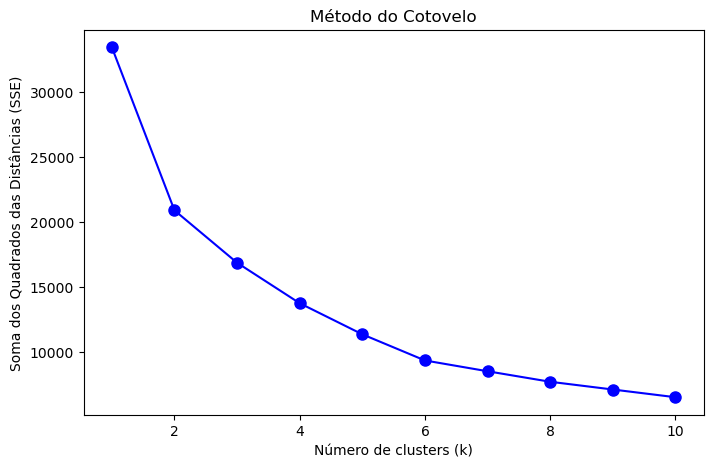

In [78]:
#Análise de Cotovelo

sse = []
K = range(1, 11)  # testando de 1 até 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Plot do gráfico de cotovelo
plt.figure(figsize=(8,5))
plt.plot(K, sse, 'bo-', markersize=8)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos Quadrados das Distâncias (SSE)')
plt.title('Método do Cotovelo')
plt.show()


k=2, silhouette médio=0.489
k=3, silhouette médio=0.411
k=4, silhouette médio=0.289
k=5, silhouette médio=0.358
k=6, silhouette médio=0.344
k=7, silhouette médio=0.350
k=8, silhouette médio=0.371
k=9, silhouette médio=0.372
k=10, silhouette médio=0.390


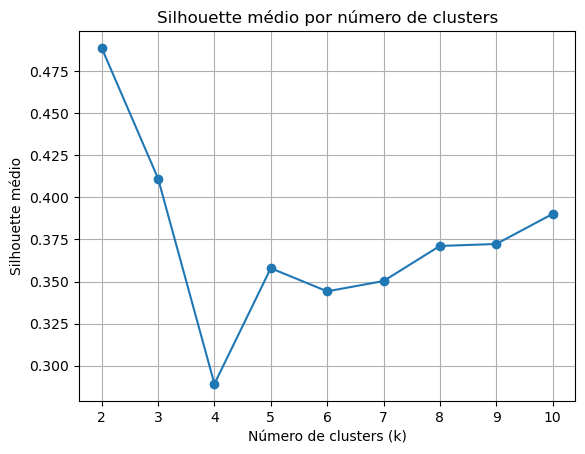

In [79]:
#Analisando Silhoutte por clusters

range_n_clusters = range(2, 11)  # Testa de 2 até 10 clusters
silhouette_avgs = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print(f"k={n_clusters}, silhouette médio={silhouette_avg:.3f}")

# Plotando para visualizar
plt.plot(range_n_clusters, silhouette_avgs, marker='o')
plt.title("Silhouette médio por número de clusters")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette médio")
plt.grid(True)
plt.show()


In [80]:
#Criando Kmeans -> usanod três que atende uma base mais segmentada e eficaz

kmeans = KMeans(n_clusters=3, random_state=42)
cliente_agg['cluster'] = kmeans.fit_predict(X_scaled)

In [81]:
from sklearn.metrics import silhouette_score, silhouette_samples

# Calcula o score médio da silhueta
silhouette_avg = silhouette_score(X_scaled, cliente_agg['cluster'])
print(f"Silhouette Score médio: {silhouette_avg:.3f}")

# Se quiser ver a silhueta de cada ponto:
sample_silhouette_values = silhouette_samples(X_scaled, cliente_agg['cluster'])
cliente_agg['silhouette'] = sample_silhouette_values

# Distribuição da silhueta por cluster
print(cliente_agg.groupby('cluster')['silhouette'].mean())


Silhouette Score médio: 0.411
cluster
0    0.457894
1    0.301266
2    0.212384
Name: silhouette, dtype: float64


Explorando KMeans

In [82]:
cluster_summary = cliente_agg.groupby('cluster')[features].mean().round(3)
cluster_summary.head()

,num_pedidos,total_passagens,valor_total_gasto,pct_viagens_ida_e_volta,pct_compras_coletivas,eh_primeira_compra,dias_ativo,frequencia_media_dias,recencia_dias,comprador_unico
cluster,,,,,,,,,,
0,1.000,1.309,152.281,0.006,0.240,0.552,1.000,1.000,1211.351,1.000
1,2.548,3.584,403.413,0.005,0.203,0.284,591.263,187.618,636.479,0.000
2,2.265,2.889,294.235,0.020,0.176,0.305,103.220,41.419,925.980,0.017


Tabela de Clientes <> Cluster

In [83]:
# Tabela final com client_id e cluster
clientes_com_cluster = cliente_agg[['client_id', 'cluster']]

clientes_com_cluster.head()

,client_id,cluster
0,000be0ddb26c78032de953313a60adbaf30a9492fd70b8...,1
1,003e92c14650be88db51eeeb35ff0b564b3fd0d4c7de07...,0
2,004aa4dbc4e35d318a0201065335aa2fe95c78abe9573f...,1
3,005f0cea80f8be9587925f8c86aa3403a2bd2f9c02362f...,0
4,0072b4fde666a48136cb9bf1dce535d5c5b2031c412199...,1


In [ ]:
#Criando CSV para download
clientes_com_cluster.to_csv('clientes_com_clusterv2.csv', index=False)